# Run this in the CLIMADA environment and if you encounter any problems run !pip uninstall pyrepo-mcda

In [30]:
# Install the required package

!pip install pyrepo-mcda

# Part 1: Creating the data frame metrics_df

* The metrics_df holds the data frame fed to the MCDM module.
* It is the raw data frame before organizing columns and cell values into alternatives, groups, and uncertainty-specific categories, and allocating unique IDs to each group, alternative, criteria, etc ...
* For this, we need to calculate the metrics dataframe using a wrapper function of the Cost-Benefit and UNSEQUA.

### Define the entities objects to investigate

* Entities should be defined in the following way:

  - with a key referring to a reference name, for example, 'Assets', 'People', 'Infrastructure', or even 'Data_Provider_1' and 'Data_Provider_2'
  - and a value being the entity object for the current and future year

* Example:

    ```python
    ent_dict = {
        'Assets': {'today': Entity(), 'future': Entity()},
        'People': {'today': Entity(), 'future': Entity()},
        'Infrastructure': {'today': Entity(), 'future': Entity()}
    }

### Load the DEMO entitites and hazards

* Defines the entity and hazard set to be used
* Choose the two following options for the file_str variable, begin with CLIMADA_DEMO:
    * 'CLIMADA_DEMO' - CLIMADA demo entity and hazard set TC  (Does not work for Part 4 – Groups)
    * 'CanTho_PLFL' - Can Tho, Vietnam and flood hazard (Based on the ECA Case Study ECA Vietnam, Compound Flood Risk and Heat Waves

In [31]:
# *************** User-modifiable parameters ***************

file_str = 'CLIMADA_DEMO'   # or 'CLIMADA_DEMO'  'CanTho_PLFL'

# *************** End of user-modifiable parameters ***************


In [32]:
from climada.entity import Entity
from climada.util.constants import ENT_DEMO_TODAY, ENT_DEMO_FUTURE, HAZ_DEMO_H5
from climada.util.api_client import Client
from climada.hazard import Hazard

from MCDM.utils import CURRENT_YEAR, FUTURE_YEAR
import copy


## Entities and hazards containers

# Parameters
grwth_rate_dict = {'People': 0.02, 'Assets': 0.02 } # growth rate for the future exposure data

# Load the entities and hazards
if file_str == 'CLIMADA_DEMO':
    ## Entities
    ent_dict = {'Assets': {'today': Entity.from_excel(ENT_DEMO_TODAY), 'future':Entity.from_excel(ENT_DEMO_FUTURE)}}
    ## Hazards
    haz_dict = {'TCs': {'today': Hazard.from_hdf5(HAZ_DEMO_H5), 'future': Hazard.from_hdf5(HAZ_DEMO_H5)}}
    haz_dict['TCs']['future'].intensity *= 1.5 # double the intensity of the future hazard


elif file_str == 'CanTho_PLFL':

    ## Entities
    # Current exposure data - Assets and People
    ent_dict=   {'Assets': {'today': Entity.from_excel('Data/Entities/entity_TODAY_CanTho_PLFL_Assets.xlsx')},
                'People': {'today': Entity.from_excel('Data/Entities/entity_TODAY_CanTho_PLFL_People.xlsx')}
                }
    # Future exposure data - Assets
    ent_dict['Assets']['future'] = copy.deepcopy(ent_dict['Assets']['today'])
    ent_dict['Assets']['future'].exposures.gdf.value *= (1+grwth_rate_dict['Assets'])**(FUTURE_YEAR-CURRENT_YEAR) # increase the value of the future exposure data given the growth rate
    # Future exposure data - People
    ent_dict['People']['future'] = copy.deepcopy(ent_dict['People']['today'])
    ent_dict['People']['future'].exposures.gdf.value *= (1+grwth_rate_dict['People'])**(FUTURE_YEAR-CURRENT_YEAR) 

    ## Hazards
    # API client
    client = Client()
    # Hazards
    haz_dict = {'river_flood': {'today': client.get_hazard(hazard_type='river_flood', properties={'country_iso3alpha': 'VNM', 'climate_scenario': 'historical'}),
                                'future': client.get_hazard(hazard_type='river_flood', properties={'country_iso3alpha': 'VNM', 'climate_scenario': 'rcp26', 'year_range': '2030_2050'})
                                }
                }




/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/vwattin/anaconda3/envs/climada_env/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### Generate the metrics data frame

In [33]:
from MCDM.utils import generate_metrics, RISK_FNCS_DICT # Import the risk functions dictionary (default risk functions are defined in the utils.py file)
import pandas as pd
from tabulate import tabulate
from IPython.display import clear_output
import numpy as np

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_df = pd.read_csv(f'Data/Metrics/{file_str}.csv')
except:
    #%% Generate metrics dataframe
    metrics_df = generate_metrics(haz_dict, ent_dict, risk_fncs_dict = RISK_FNCS_DICT, file_output = file_str)

    # Add additional fictive metrics to the dataframe - APPROV and FEAS
    temp_df = pd.DataFrame(metrics_df['measure'].unique(), columns=['measure'])
    temp_df['approv'] = [np.random.randint(1, 5) for _ in range(len(temp_df))]
    temp_df['feas'] = np.random.rand(len(temp_df))
    extra_metrics_df = pd.merge(metrics_df, temp_df, on='measure')

# Clear the cell output to avoid output from the print statement when calling the cost-benefit calculation  
# However, if intrested in the output, comment the following line
clear_output()

# Print the first few rows of the dataframe
print(f'Metrics in the {file_str} file')
print('---------------------------')
print(tabulate(metrics_df.head(), headers='keys', tablefmt='psql'))
# Get all the columns of the dataframe ben_ or bcr_ or npv_ + RISK_FNCS_DICT.keys() + ent_dict.keys()
all_crit_cols = [col for col in metrics_df.columns if 'ben_' in col or 'bcr_' in col or 'npv_' in col or 'approv' in col or 'cost' in col or 'feas' in col]
print(f'The criteria columns of the metrics dataframe are: \n{all_crit_cols}')
print('---------------------------')




Metrics in the CLIMADA_DEMO file
---------------------------
+----+-------------------+----------+------------+---------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+----------+----------+
|    | measure           | hazard   | haz_type   |   cost_Assets |   ben_aai_Assets |   bcr_aai_Assets |   npv_aai_Assets |   ben_rp250_Assets |   bcr_rp250_Assets |   npv_rp250_Assets |   approv |     feas |
|----+-------------------+----------+------------+---------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+----------+----------|
|  0 | Beach nourishment | TCs      | TC         |   1.728e+09   |      4.5172e+09  |      2.61412     |      1.08382e+10 |        2.99569e+11 |            173.361 |        7.72525e+11 |        3 | 0.337511 |
|  1 | Building code     | TCs      | TC         |   9.2e+09     |      3.83884e+09 |      0.417265    

## Description metrics – Criteria of choice

* Below you find the possible risk metrics to be picked as criteria.
* As described in the [cost-benefit module](https://climada-python.readthedocs.io/en/stable/tutorial/climada_engine_CostBenefit.html), the risk metrics given by the CB module represent the total NPV of the risk for each year.




| Metric            | Description                                                         | Objective | Example Utility |
|-------------------|---------------------------------------------------------------------|-----------|-----------------|
| cost_Assets       | Discounted cost of the measure given by entity named "Assets"                          | Minimize  |                 |
| ben_aai_Assets    | Averted risk in comparison to no measure, based on avg. annual impact             | Maximize  | |
| bcr_aai_Assets    | Benefit-to-cost ratio, based on avg. annual impact                  | Maximize  | Identifies cost-effective measures. Usefule for excluding, i.e., filtering, non-cost-efficient measures.                |
| npv_aai_Assets    | Total NPV of risk, with measure, based on avg. annual impact        | Minimize  | Enables identification of intolerable risk levels, such as assets or populations remaining at risk. |
| ben_rp250_Assets  | Averted risk in comparison to no measure, based on 250-year return period         | Maximize  | Highlights measures reducing extreme risk |
| bcr_rp250_Assets  | Benefit-to-cost ratio, based on 250-year return period              | Maximize  |                 |
| npv_rp250_Assets  | Total NPV of risk, with measure, based on 250-year return period    | Minimize  |                 |
| approv            | Criteria values representing public approval                        | Maximize  |                 |
| feas              | Criteria values representing feasibility                            | Maximize  |                 |


# Part 2: Ranking the alternatives

* Below you will perform your first MCDM rankings 

## Initialize the decision matrix object and rank 

In [34]:
# *************** User-modifiable parameters ***************

alt_cols = ['measure'] # Columns in metrics_df that contains the alternatives
crit_cols = [col for col in all_crit_cols if 'bcr' not in col and 'npv' not in col] # Columns in metrics_df that contains the criteria
objectives = {crit: -1 if 'cost' in crit else 1 for crit in crit_cols} # Dictionary of objectives
weights = {} # Dictionary of weights. Default is equal for all criteria

# *************** End of user-modifiable parameters ***************

The available alternatives are:
---------------------------
+----+------------------+-------------------+
|    | Alternative ID   | measure           |
|----+------------------+-------------------|
|  0 | A1               | Beach nourishment |
|  1 | A2               | Building code     |
|  2 | A3               | Mangroves         |
|  3 | A4               | Seawall           |
|  4 | A5               | no measure        |
+----+------------------+-------------------+


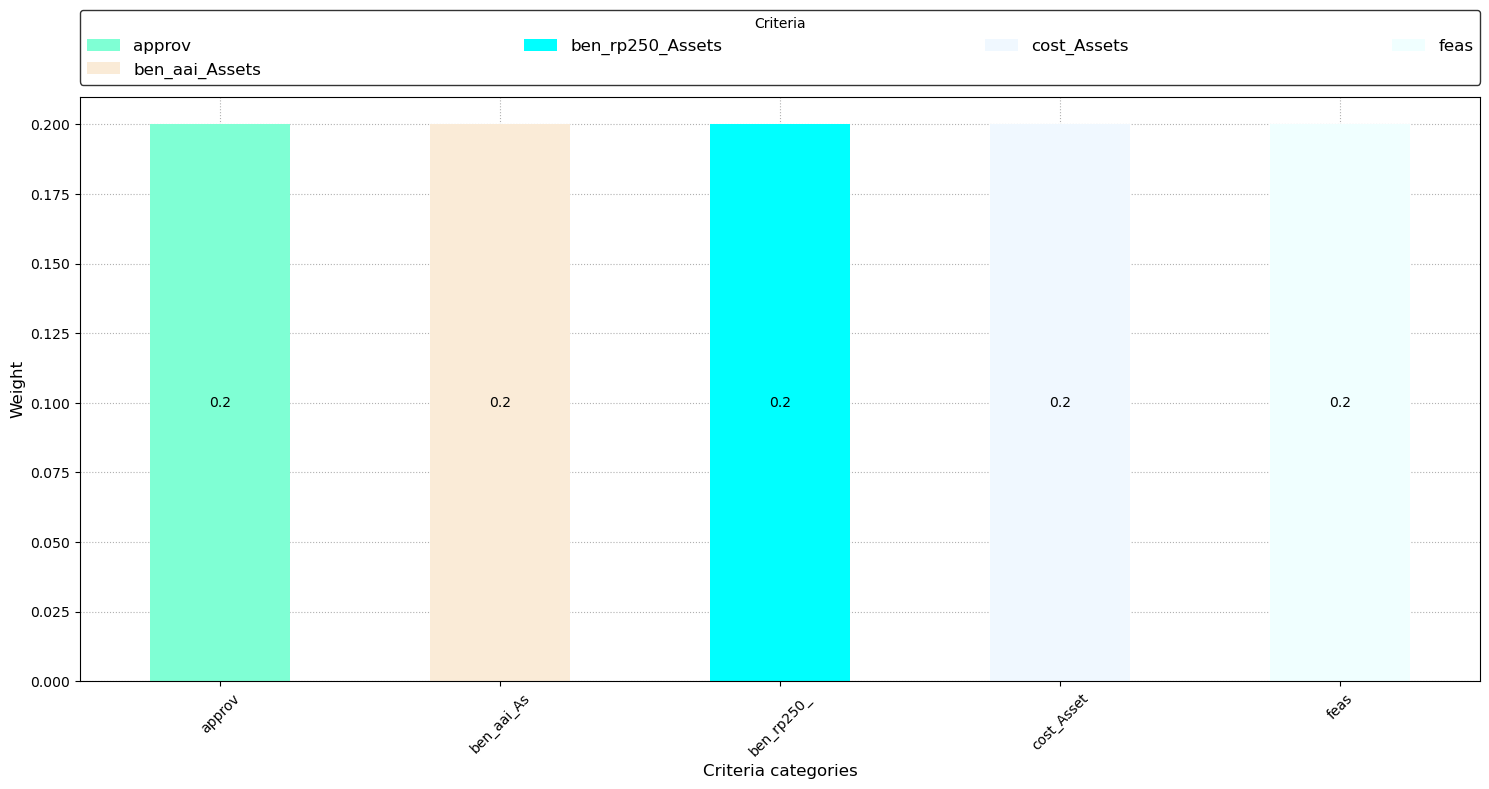

In [35]:
from MCDM.DecisionMatrix import DecisionMatrix  # Import DecisionMatrix module

# Initialize the decision matrix object
dm = DecisionMatrix(metrics_df=metrics_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols)

# Print the alternatives
print('The available alternatives are:')
print('---------------------------')
print(tabulate(dm.alternatives_df, headers='keys', tablefmt='psql'))

# Plot the criteria weights
dm.plot_criteria()

# Rank the alternatives
ranks_output = dm.calc_rankings()

### Display the rankings only for the individual criteria, excluding the MCDM rankings

The performance of the alternatives based on each criteria is:
---------------------------
+------------------+-------------------+---------------+------------------+--------------------+----------+--------+
| Alternative ID   | measure           |   cost_Assets |   ben_aai_Assets |   ben_rp250_Assets |   approv |   feas |
|------------------+-------------------+---------------+------------------+--------------------+----------+--------|
| A1               | Beach nourishment |             3 |                2 |                  2 |        3 |      4 |
| A2               | Building code     |             5 |                3 |                  3 |        1 |      5 |
| A3               | Mangroves         |             2 |                1 |                  1 |        1 |      2 |
| A4               | Seawall           |             4 |                4 |                  4 |        3 |      1 |
| A5               | no measure        |             1 |                5 |               

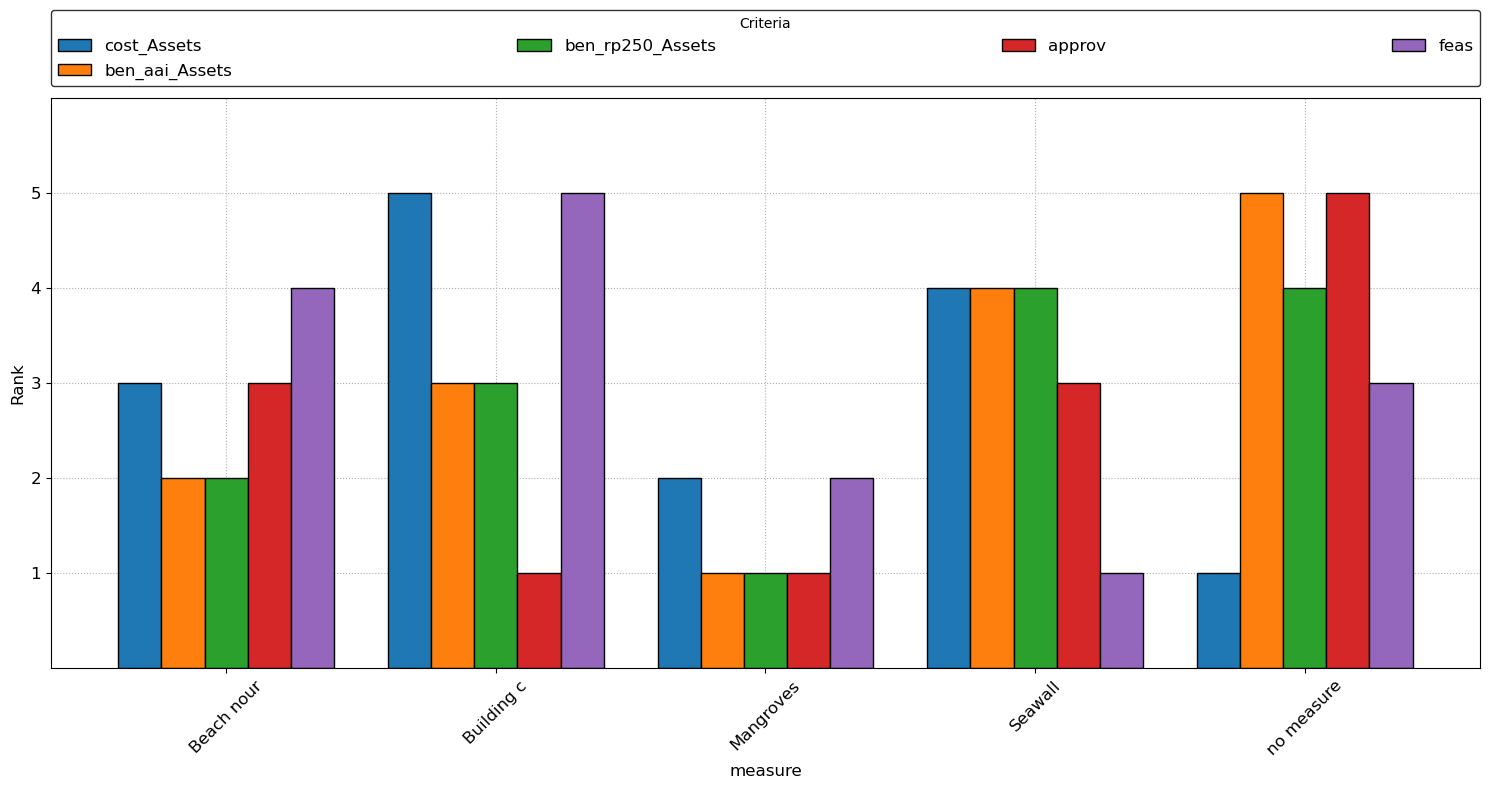

In [36]:
print('The performance of the alternatives based on each criteria is:')
print('---------------------------')
# Print the rankings - Criteria
ranks_output.print_rankings(rank_type='criteria')
print('---------------------------')
print('Is any alternative clearly dominating the others?')
# Plot the rankings -Criteria
ranks_output.plot_ranks( alt_name_col = 'measure', rank_type='criteria')

## Display the rankings of the MCDM methods

### Description of MCDM ranking methods

* Below you find a table of the default MCDM ranking methods 





| Method (Full Name)             | Approach & Application                                                                                                    | Decision Maker's Risk Profile                                                                                                                      |
|--------------------------------|----------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| Simple Additive Weighting (SAW) | Additive weighting: SAW simply adds up the normalized values for each criterion, after multiplying them by their respective weights. This method is straightforward and works well when all criteria are well-understood and can be quantifiably expressed, making it an attractive choice for decision-makers who prefer clarity and simplicity in their evaluation process. | Ideal for decision-makers who value straightforward evaluations and are comfortable with decisions where the criteria are well-understood and quantifiable. |
| Technique for Order of Preference by Similarity to Ideal Solution (TOPSIS) | Distance-based evaluation: TOPSIS assesses alternatives by determining their proximity to the most desirable (ideal) scenario and their distance from the least desirable (anti-ideal) scenario. It suits decision-makers who aim for a balanced approach, seeking an alternative that performs well across all considered criteria, thereby reflecting a moderate aversion to unfavorable outcomes. | Suited for those who seek a balanced solution that is as good as possible across all criteria, showing a moderate aversion to outcomes that are far from the best possible scenario. |
| VIKOR | Compromise solution: VIKOR seeks an alternative that provides the best compromise between the ideal and the least desirable outcomes across all criteria. It's particularly effective for decision-makers inclined towards caution, aiming to ensure that selected options do not deviate significantly from acceptable standards in any of the considered aspects. | Perfect for cautious decision-makers looking to minimize exposure to the worst outcomes in any criterion, ensuring no option is too far from an acceptable outcome. |
| Copeland (Ensemble Approach) | Ensemble ranking: The Copeland method synthesizes insights from multiple MCDM methods by conducting pairwise comparisons among alternatives, culminating in a unified ranking. This method is especially useful for integrating diverse perspectives, thus reducing the impact of specific biases or limitations associated with individual decision-making frameworks. | This approach balances various risk profiles, integrating insights from multiple methods to reduce sensitivity to any one method's parameters or weights. |


The performance of the alternatives given by the MCDM methods is:
---------------------------
+------------------+-------------------+----------+-------+---------+------------+
| Alternative ID   | measure           |   Topsis |   Saw |   Vikor |   copeland |
|------------------+-------------------+----------+-------+---------+------------|
| A3               | Mangroves         |        1 |     1 |       1 |          1 |
| A1               | Beach nourishment |        2 |     2 |       2 |          2 |
| A2               | Building code     |        3 |     3 |       3 |          3 |
| A4               | Seawall           |        4 |     5 |       4 |          4 |
| A5               | no measure        |        5 |     4 |       5 |          5 |
+------------------+-------------------+----------+-------+---------+------------+




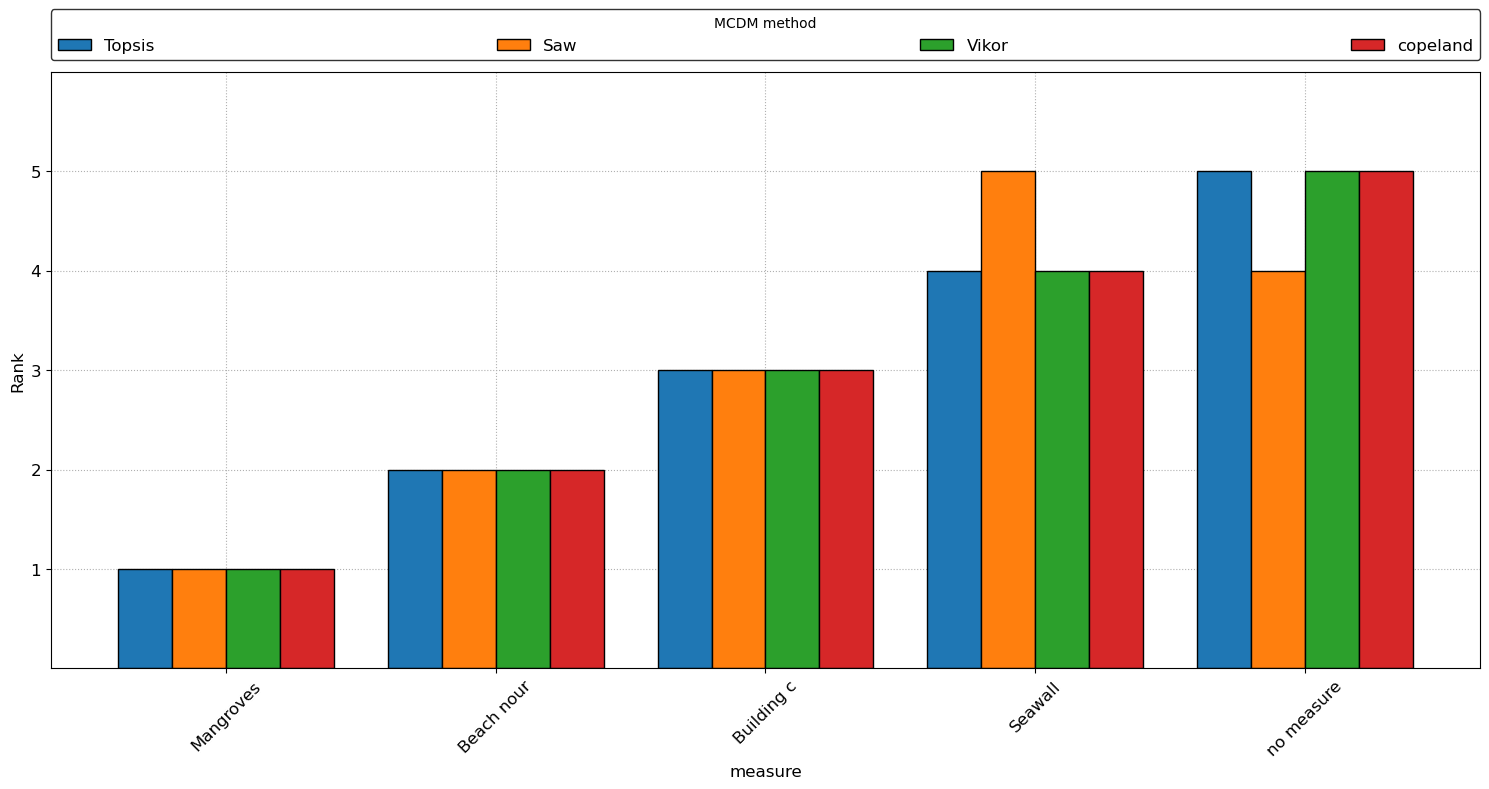

In [37]:
print('The performance of the alternatives given by the MCDM methods is:')
print('---------------------------')
# Print the rankings - MCDM methods
ranks_output.print_rankings(rank_type='MCDM', sort_by_col='copeland')
# Plot the rankings - MCDM methods
ranks_output.plot_ranks(alt_name_col = 'measure', rank_type='MCDM', sort_by_col='copeland', transpose=False)

## Customized ranking and filtering

* If you want to use other MCDM ranking methods, with specific parameters, you are able to do so below
* You can alos derive new criteria based on the criteria given, see 'derived_columns' below
* You can filter out alternatives that does not satisfy certain 'constraints' before perfroming the ranking

In [38]:
# Define the MCDM ranking methods
from pyrepo_mcda.mcda_methods import AHP, TOPSIS, SAW, VIKOR #  SPOTIS, ARAS, COCOSO, CODAS, COPRAS, CRADIS, EDAS, MABAC, MARCOS, MULTIMOORA, MULTIMOORA_RS, PROMETHEE_II, PROSA_C,, VMCM, WASPAS, VIKOR_SMAA
from pyrepo_mcda.compromise_rankings import copeland, dominance_directed_graph, rank_position_method
from pyrepo_mcda import distance_metrics as dists
from pyrepo_mcda import normalizations as norms

In [39]:
# *************** User-modifiable parameters ***************

# Define the MCDM ranking methods
mcdm_methods = {'AHP': AHP(), # Analytic Hierarchy Process default parameters
          'Topsis': TOPSIS(), # Technique for Order Preference by Similarity to Ideal Solution default parameters
          'Saw': SAW(), # Simple Additive Weighting default parameters
          'Custom_Topsis': TOPSIS(normalization_method = norms.minmax_normalization, distance_metric = dists.euclidean) # Custom method with customized normalization and distance methdods
    }

# Define the compromised ranking function of the rank matrices
comp_ranks = {'copeland': copeland,
      }

# Dictionary of derived columns and their functions
derived_columns = {'bcr': lambda df: df['ben_aai_Assets']/df['cost_Assets']}

# Apply a constraint to the decision matrix
# You find the filter definition in the utils.py file in the function filter_df
constraints = {'ben_aai_Assets': {'greater': 0},
                 # 'cost_Assets': {'less': 5000000},
                  'bcr': {'greater': 1} # Benefit-cost ratio greater than 1 (Given the derived column above, this is equivalent to the benefit being greater than the cost)
                  }

# *************** End of user-modifiable parameters ***************

Table below shows the excluded alternatives, i.e., not satifying constraints,
where True if particular constraint is satisfied and False if not. 
.
.
+----+------------------+---------------+------------------+-------+
|    | Alternative ID   | measure       | ben_aai_Assets   | bcr   |
|----+------------------+---------------+------------------+-------|
|  0 | A2               | Building code | True             | False |
|  1 | A4               | Seawall       | True             | False |
|  2 | A5               | no measure    | False            | False |
+----+------------------+---------------+------------------+-------+


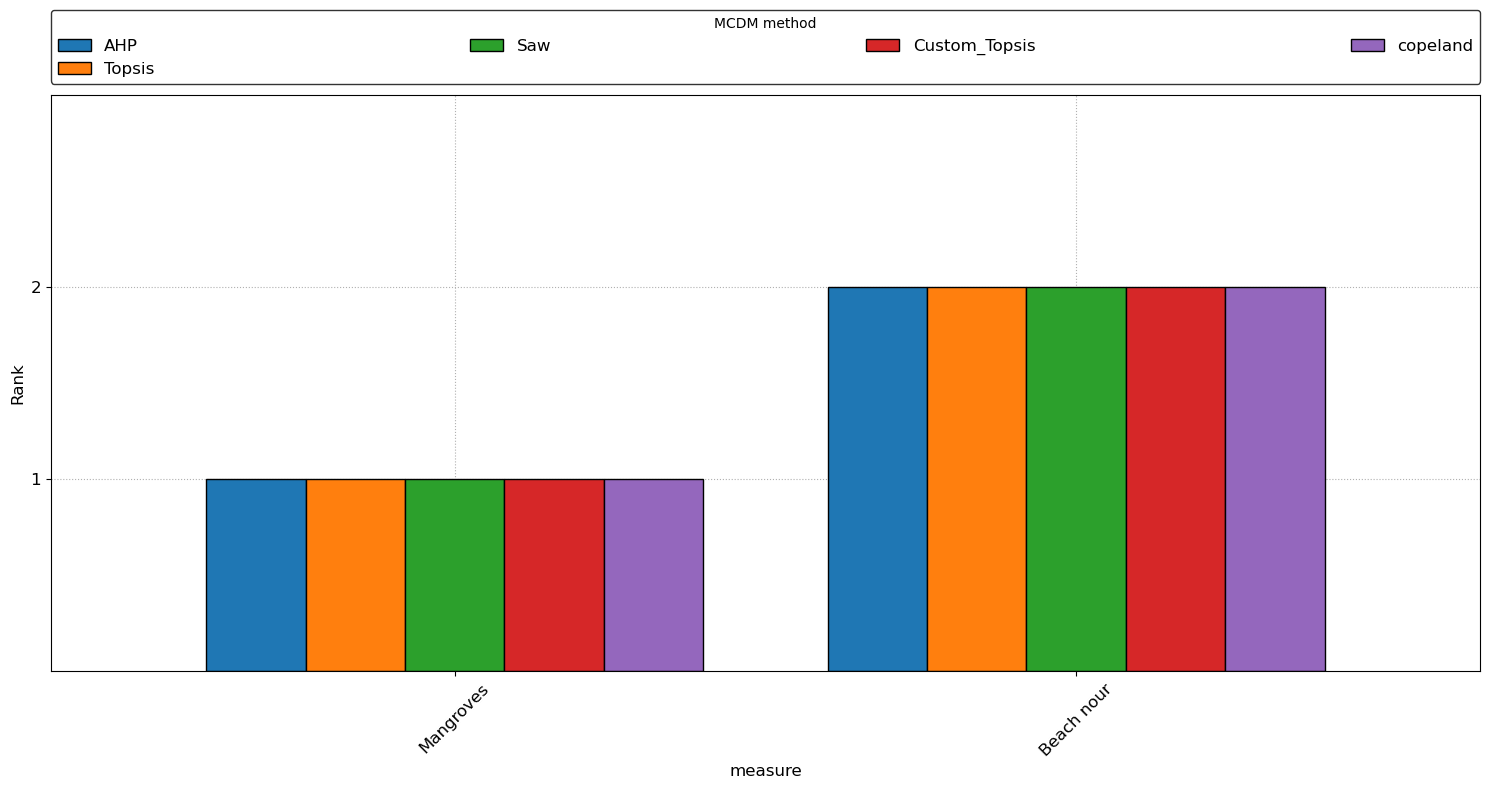

In [40]:
# Calculate the rankings
ranks_output = dm.calc_rankings( mcdm_methods, comp_ranks, constraints=constraints, derived_columns=derived_columns)
clear_output()


# Check if ranks_output has an attribute alt_exc_const_df
if hasattr(ranks_output, 'alt_exc_const_df'):
    # Print the alternatives that do not satisfy the constraints
    print("Table below shows the excluded alternatives, i.e., not satifying constraints,\nwhere True if particular constraint is satisfied and False if not.", 2*"\n.")
    print(tabulate(ranks_output.alt_exc_const_df, headers='keys', tablefmt='psql'))

# Plot the rankings
ranks_output.plot_ranks(disp_rnk_cols=[], rank_type='MCDM', sort_by_col='copeland', transpose=False, alt_name_col='measure')


# Part 3 – Weight sensitivities and preferences 

* In this section you can investigate how well each alterntive performs given a single, or set of, criteria increases the weight.

In [41]:
# *************** User-modifiable parameters ***************

crit_cols_dict = {'MONEY': ['cost_Assets','ben_aai_Assets', 'ben_rp250_Assets']} # Dictionary of criteria categories and their criteria columns

# *************** End of user-modifiable parameters ***************

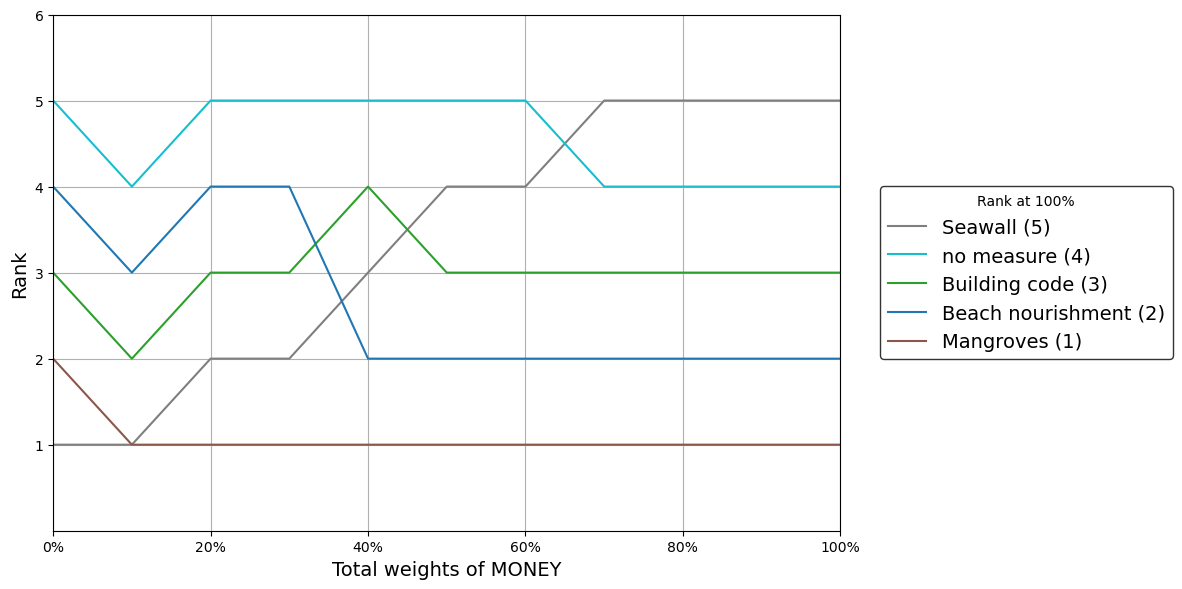

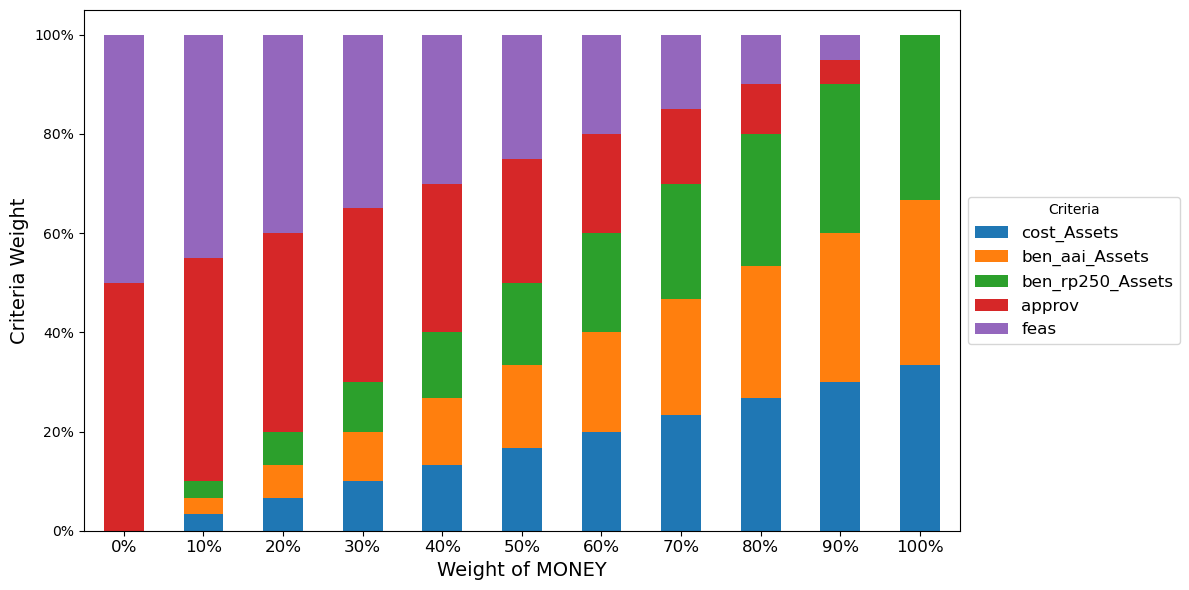

In [42]:
# Calculate the sensitivity of the rankings to the weights of the criteria
sensitivity_df = dm.calc_imprt_sensitivity(crit_cols_dict=crit_cols_dict, mcdm_methods=mcdm_methods, comp_ranks=comp_ranks, alt_tag='measure')

## Criteria categories

* You can categorize criteria to different criteria categories.
* This can help 
    * For plotting weights - to see how the toal weight of 100% is allocated
    * If you want filter out certain criteria categories when ranking  

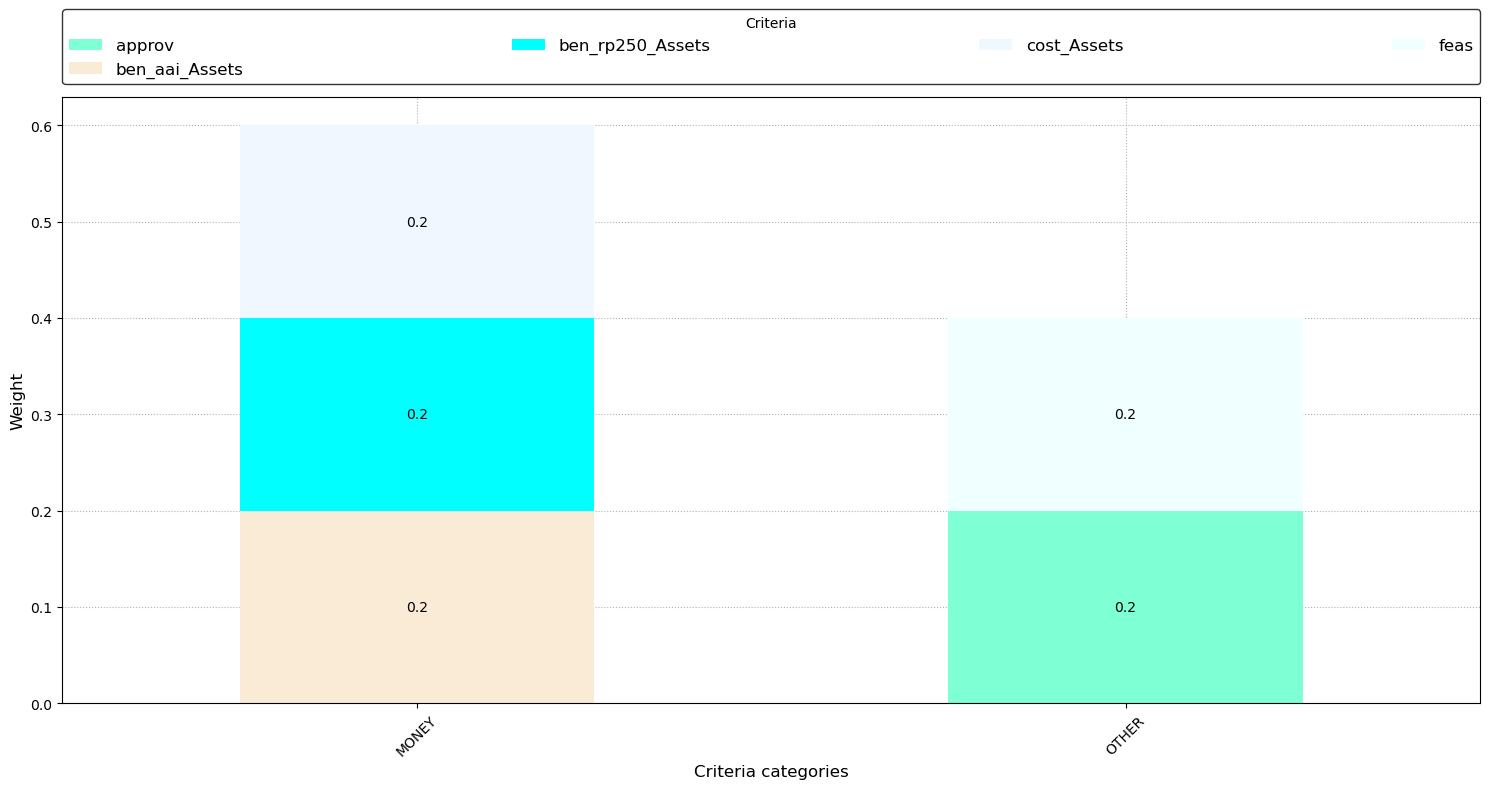

In [43]:
# Initialize the decision matrix object and include more criteria

# categorize the criteria assets and people
crit_cats = {'MONEY': ['ben_aai_Assets',  'ben_rp250_Assets', 'cost_Assets'],
             'PEOPLE': ['ben_aai_People', 'ben_rp250_People'],
             'OTHER': ['approv', 'feas']}


# Initialize the decision matrix object
dm = DecisionMatrix(metrics_df=metrics_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols, crit_cats=crit_cats)

# Plot the criteria weights
dm.plot_criteria(group_by_category=True)

# Part 3 - Incorporating uncertainties

* Using UNSEQUA, we can derive rik metrics for different uncertainty varibles 
* Below you can define uncertainty varibles if you present your own entity objects
* For the DEMO case, to speed up calcualtions, the risk metrics based on the uncertainty varible samples have already been calculated based on below defintions   

## Define the uncertainty variables

In [44]:
# Uncertainty variables
import scipy as sp

# *************** User-modifiable parameters ***************

# Do not modify the function names, e.g, ent_today_func, and dont remove the keyword arguments ent_today_base, ent_fut_base, haz_today_base, haz_fut_base !!!

# Uncertainty variable distributions
unc_var_dist_dict = {"x_ent": sp.stats.uniform(0.7, 1),
                     "m_fut_cost": sp.stats.norm(1, 0.1),
                     "x_haz_today": sp.stats.uniform(1, 3),
                     "x_haz_fut": sp.stats.uniform(1, 3)}

# Base functions
# Entity today has an uncertainty in the total asset value
def ent_today_func(x_ent, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    entity = copy.deepcopy(ent_today_base)
    entity.exposures.ref_year = CURRENT_YEAR
    entity.exposures.gdf.value *= x_ent
    return entity

# Entity in the future has a +- 10% uncertainty in the cost of all the adapatation measures
def ent_fut_func(m_fut_cost, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    entity = copy.deepcopy(ent_today_base)
    entity.exposures.ref_year = FUTURE_YEAR
    for meas in entity.measures.get_measure(haz_today_base.haz_type):
        meas.cost *= m_fut_cost
    return entity

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_today_func(x_haz_today, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    haz = copy.deepcopy(haz_today_base)
    haz.intensity = haz.intensity.multiply(x_haz_today)
    return haz

# The hazard intensity in the future is also uncertainty by a multiplicative factor
def haz_fut_func(x_haz_fut, ent_today_base=None, ent_fut_base=None, haz_today_base=None, haz_fut_base=None):
    haz = copy.deepcopy(haz_fut_base)
    haz.intensity = haz.intensity.multiply(x_haz_fut)
    return haz

# *************** End of user-modifiable parameters ***************


## Generate the metrics data frame

In [45]:
from MCDM.utils import generate_unc_func_dist_dict

# Creaate the uncertainty functions dictionary input variable
unc_func_dist_dict = generate_unc_func_dist_dict(func_dict= {'ent_today': ent_today_func, 'ent_fut': ent_fut_func, 'haz_today': haz_today_func, 'haz_fut': haz_fut_func}, unc_var_dist_dict= unc_var_dist_dict)

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_unc_df = pd.read_csv('Data/Metrics/{}.csv'.format(file_str + '_unc'))
except:
    #%% Generate metrics dataframe
    if file_str == 'CLIMADA_DEMO':
        n_samples = 100
    else:
        n_samples = 1 # You can increase the number of samples but very slow for the CanTho_PLFL case

    # Generate the metrics dataframe
    metrics_unc_df = generate_metrics(haz_dict, ent_dict, unc_func_dist_dict = unc_func_dist_dict, risk_fncs_dict = RISK_FNCS_DICT, n_samples= n_samples, future_year=FUTURE_YEAR, current_year=CURRENT_YEAR, file_output = file_str + '_unc')


# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
clear_output()

# Print the first few rows of the dataframe
print("\n.", "Table below shows the first few rows of the dataframe with the uncertainty samples.", 2*"\n.")
print(tabulate(metrics_unc_df.head(), headers='keys', tablefmt='psql'))


. Table below shows the first few rows of the dataframe with the uncertainty samples. 
.
.
+----+-------------------+----------+------------+----------+--------------+---------------+-------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+---------------+----------+----------+
|    | measure           | hazard   | haz_type   |    x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   ben_aai_Assets |   bcr_aai_Assets |   npv_aai_Assets |   ben_rp250_Assets |   bcr_rp250_Assets |   npv_rp250_Assets |   cost_Assets |   approv |     feas |
|----+-------------------+----------+------------+----------+--------------+---------------+-------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+---------------+----------+----------|
|  0 | Beach nourishment | TCs      | TC         | 0.703906 |     0.997062 |       1.92578 |     1.73828 |      7

## Calculate and display the ranks

In [46]:
# *************** User-modifiable parameters ***************

# Define the uncertainty variables
unc_cols = [key for key in unc_var_dist_dict] # Columns in metrics_df that contains the uncertainty variables

# *************** End of user-modifiable parameters ***************


# Initialize the decision matrix object
dm_unc = DecisionMatrix(metrics_df=metrics_unc_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols, unc_cols=unc_cols)

# Rank the alternatives
ranks_output_unc = dm_unc.calc_rankings()
clear_output()

# Print the sample dataframe (first few rows)
print("\n.", "Table below shows the dataframe with the unique uncertainty samples.", 2*"\n.")
print("_"*100)
print(tabulate(dm_unc.metrics_df.head(), headers='keys', tablefmt='psql'))





. Table below shows the dataframe with the unique uncertainty samples. 
.
.
____________________________________________________________________________________________________
+----+-------------------+----------+------------+----------+--------------+---------------+-------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+---------------+----------+----------+
|    | measure           | hazard   | haz_type   |    x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   ben_aai_Assets |   bcr_aai_Assets |   npv_aai_Assets |   ben_rp250_Assets |   bcr_rp250_Assets |   npv_rp250_Assets |   cost_Assets |   approv |     feas |
|----+-------------------+----------+------------+----------+--------------+---------------+-------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+---------------+----------+----------|
|  0 | Beach nourishment | 

## Display the results

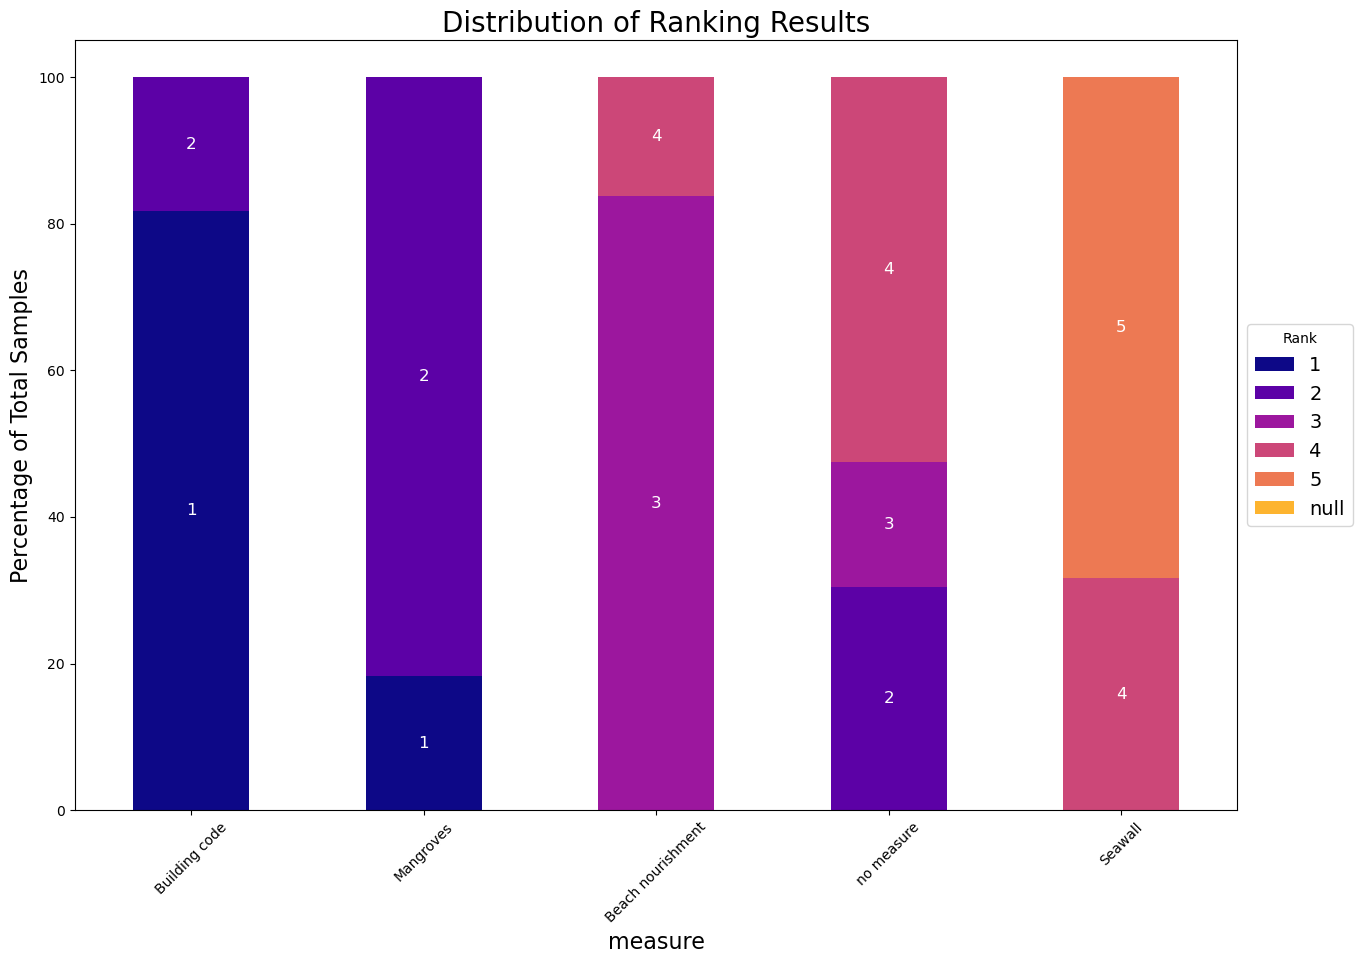

In [47]:
# Plot the rankings
ranks_output_unc.plot_rank_distribution(disp_rnk_col='copeland', alt_name_col='measure')

## Look at samples where each measure performs well and poor  

In [48]:
# Print the top and bottom 5 alternatives for each measure
for measure in ranks_output_unc.ranks_MCDM_df['measure'].unique():
    # Filter the dataframe for the current measure
    measure_df = ranks_output_unc.ranks_MCDM_df[ranks_output_unc.ranks_MCDM_df['measure'] == measure]
    # Drop the Group ID column
    measure_df.drop(columns='Group ID', inplace=True)

    # Sort the filtered dataframe on the 'copeland' column
    measure_df.sort_values(by='copeland', ascending=True, inplace=True)

    # Print the top 5 performance
    print(f"The top 5 sample ID for the measure {measure} are:")
    print(tabulate(measure_df.head(5), headers='keys', tablefmt='psql'))

    # Print the bottom 5 performance
    print(f"The bottom 5 sample ID for the measure {measure} are:")
    print(tabulate(measure_df.tail(5), headers='keys', tablefmt='psql'))

    print('---------------------------')
    print("\n.")


The top 5 sample ID for the measure Beach nourishment are:
+------+------------------+-------------------+-------------+----------+--------------+---------------+-------------+----------+-------+---------+------------+
|      | Alternative ID   | measure           | Sample ID   |    x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   Topsis |   Saw |   Vikor |   copeland |
|------+------------------+-------------------+-------------+----------+--------------+---------------+-------------+----------+-------+---------+------------|
|    0 | A1               | Beach nourishment | S1          | 0.703906 |     0.997062 |       1.92578 |     1.73828 |        3 |     4 |       3 |          3 |
| 1990 | A1               | Beach nourishment | S399        | 1.36797  |     0.909825 |       3.96484 |     1.36328 |        3 |     4 |       3 |          3 |
| 1985 | A1               | Beach nourishment | S398        | 1.36797  |     0.909825 |       3.73047 |     3.26172 |        4 |     4 |     

## Filter out specific samples to rank

*Note: If the filtering conditions returns an empty data frame the 'calc_rankings' doesnt work*

In [49]:
# *************** User-modifiable parameters ***************

# Define the condition
rank_filt = {'m_fut_cost': {'range': (1.0, 1.05)},
               'x_haz_today': {'greater': 2.0}
               }

# *************** End of user-modifiable parameters ***************

In [50]:


# Rank the alternatives
filt_ranks_output_unc = dm_unc.calc_rankings(rank_filt=rank_filt)

# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
clear_output()

# Print the rankings
filt_ranks_output_unc.print_rankings()



State: S2
-----------------------------------
+------------------+-------------------+----------+--------------+---------------+-------------+----------+-------+---------+------------+
| Alternative ID   | measure           |    x_ent |   m_fut_cost |   x_haz_today |   x_haz_fut |   Topsis |   Saw |   Vikor |   copeland |
|------------------+-------------------+----------+--------------+---------------+-------------+----------+-------+---------+------------|
| A1               | Beach nourishment | 0.703906 |      1.01276 |       2.72266 |     1.92578 |        4 |     4 |       3 |          4 |
| A2               | Building code     | 0.703906 |      1.01276 |       2.72266 |     1.92578 |        1 |     1 |       2 |          1 |
| A3               | Mangroves         | 0.703906 |      1.01276 |       2.72266 |     1.92578 |        2 |     3 |       1 |          2 |
| A4               | Seawall           | 0.703906 |      1.01276 |       2.72266 |     1.92578 |        5 |     5 |     

## Derive (new) criteria as the conditional mean  

* This approach is useful for analyzing specific scenarios, i.e., sets of uncertainty variables.

The plot below shows the rankings of the alternatives based on the conditional mean of the criteria. 
.
.
+------------------+-------------------+-------+----------+-------+-----------------+------------+
| Alternative ID   | measure           |   AHP |   Topsis |   Saw |   Custom_Topsis |   copeland |
|------------------+-------------------+-------+----------+-------+-----------------+------------|
| A2               | Building code     |     1 |        1 |     1 |               1 |          1 |
| A3               | Mangroves         |     2 |        2 |     2 |               2 |          2 |
| A1               | Beach nourishment |     3 |        3 |     4 |               3 |          3 |
| A5               | no measure        |     4 |        4 |     3 |               4 |          4 |
| A4               | Seawall           |     5 |        5 |     5 |               5 |          5 |
+------------------+-------------------+-------+----------+-------+-----------------+------------+




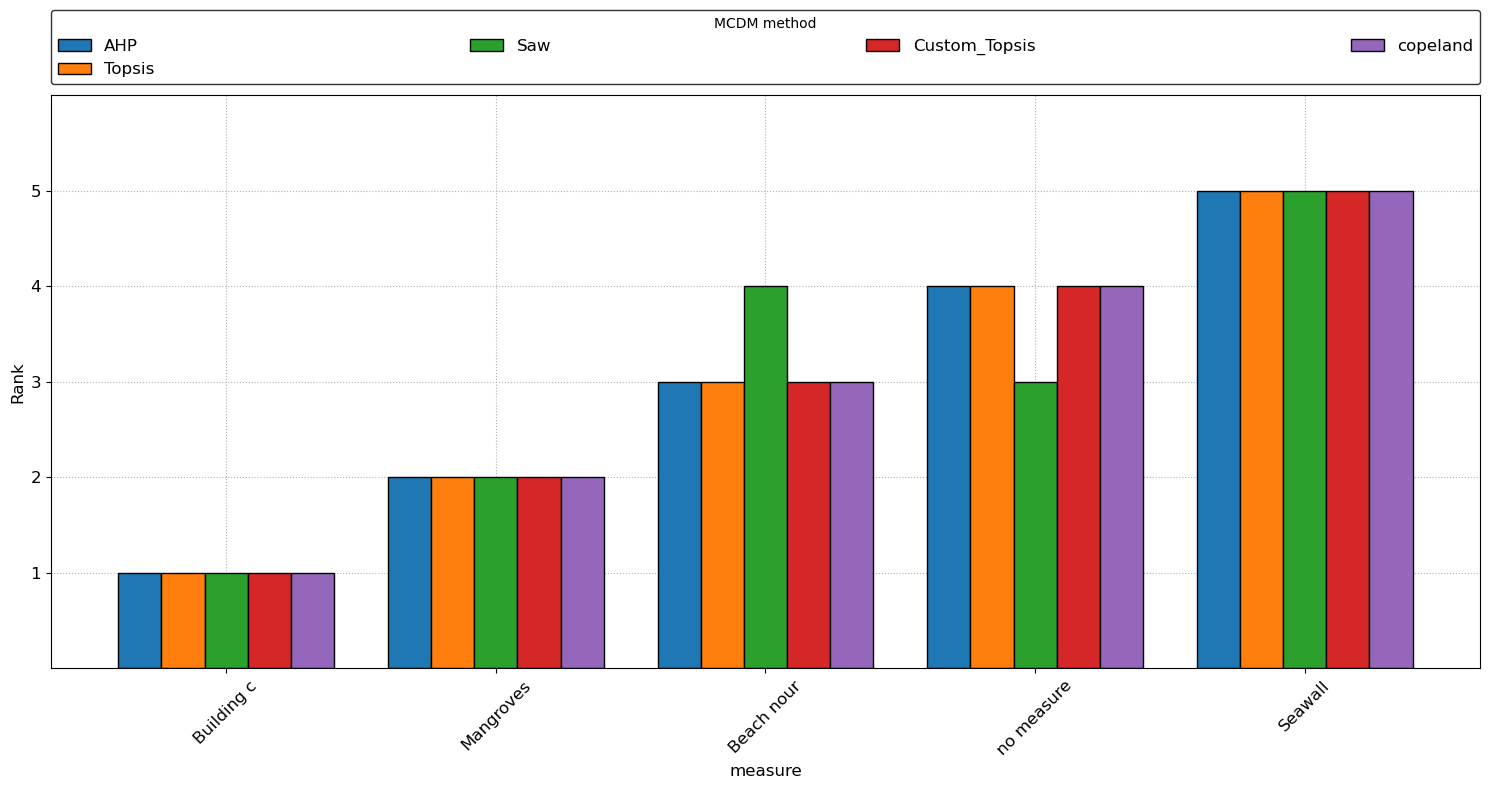

In [51]:
# *************** User-modifiable parameters ***************

# Define the condition
condition = {'m_fut_cost': {'greater': 1} # The future cost of the adaptation measures is greater than 1
                  }

# *************** End of user-modifiable parameters ***************

# Calculate the conditional mean based criteria
dm_cond_unc_mean = dm_unc.mean_based_criteria(condition=condition)

# Calculate the rankings
rnks_cond_unc_mean = dm_cond_unc_mean.calc_rankings( mcdm_methods, comp_ranks)

# Plot the rankings
print("The plot below shows the rankings of the alternatives based on the conditional mean of the criteria.", 2*"\n.")
rnks_cond_unc_mean.print_rankings(sort_by_col='copeland')
rnks_cond_unc_mean.plot_ranks(sort_by_col='copeland', alt_name_col='measure')

## Part 4 - Considering Groups (Only works for file_str = 'CanTho_PLFL': Go back to Part 1)!!!

In [52]:
# If you look at the entities exposure object, you will see that the exposure geodataframe has a description column "admin1_info"

# Print the first few rows of the exposure geodataframe
print(tabulate(ent_dict['Assets']['today'].exposures.gdf.head(), headers='keys', tablefmt='psql'))

# Print the unique set of groups in admin1_info
print("The unique set of groups in the admin1_info column is:")
print(ent_dict['Assets']['today'].exposures.gdf.admin1_info.unique())


+----+------------+-------------+-------------+--------------+-------------+-----------+--------------+
|    |   latitude |   longitude |       value |   deductible |       cover |   impf_TC |   Value_2010 |
|----+------------+-------------+-------------+--------------+-------------+-----------+--------------|
|  0 |    26.9339 |    -80.1288 | 1.39275e+10 |            0 | 1.39275e+10 |         1 |  5.1393e+09  |
|  1 |    26.9572 |    -80.0983 | 1.25961e+10 |            0 | 1.25961e+10 |         1 |  4.64799e+09 |
|  2 |    26.7838 |    -80.7489 | 1.25961e+10 |            0 | 1.25961e+10 |         1 |  4.64799e+09 |
|  3 |    26.6455 |    -80.5507 | 1.25961e+10 |            0 | 1.25961e+10 |         1 |  4.64799e+09 |
|  4 |    26.8978 |    -80.5969 | 1.25961e+10 |            0 | 1.25961e+10 |         1 |  4.64799e+09 |
+----+------------+-------------+-------------+--------------+-------------+-----------+--------------+
The unique set of groups in the admin1_info column is:


AttributeError: 'GeoDataFrame' object has no attribute 'admin1_info'

## Calc the metrics for each group

In [ ]:
# Generate the metrics dataframe but with the admin1_info column as a group column

# Check if the file exists
try:
    # Load previous metrics dataframe
    metrics_group_df = pd.read_csv('Data/Metrics/{}.csv'.format(file_str + '_group'))
except:
    #%% Generate metrics dataframe
    metrics_group_df = generate_metrics(haz_dict, ent_dict, groups = ['admin1_info'], risk_fncs_dict = RISK_FNCS_DICT, future_year=FUTURE_YEAR, current_year=CURRENT_YEAR, file_output = file_str + '_group')

# Filter out the 'ALL' group which is simply the the exposure data for the entire region
metrics_group_df = metrics_group_df[metrics_group_df['admin1_info'] != 'ALL']
# ALso filter out the 'unknown' group to make the graph more readable
metrics_group_df = metrics_group_df[metrics_group_df['admin1_info'] != 'unknown']


## Initialize the dm object

In [ ]:
# *************** User-modifiable parameters ***************

# Define the internal group weights (default is equal if none is defined) which should sum to 1
group_weights = {'admin1_info': {'Vĩnh Long': 0.7, 'Hau Giang': 0.3}}

# *************** End of user-modifiable parameters ***************

In [ ]:
# Initialize the decision matrix object
dm_groups = DecisionMatrix(metrics_df=metrics_group_df, objectives=objectives, alt_cols=alt_cols, crit_cols=crit_cols,
                           group_cols=['admin1_info'], group_weights= group_weights )

# Print the groups
print(2*'.\n')
print('The available groups and the internal group weights for the specific group are:')
print('---------------------------')
print(tabulate(dm_groups.group_weights['admin1_info'], headers='keys', tablefmt='psql'))

.
.

The available groups and the internal group weights for the specific group are:
---------------------------
+----+---------------+----------+
|    | admin1_info   |   Weight |
|----+---------------+----------|
|  1 | Hau Giang     |      0.3 |
|  2 | Vĩnh Long     |      0.7 |
+----+---------------+----------+


## Calc ranks for each group

In [ ]:
# You can either look at the rankings of the alternatives for each group or the rankings of the groups themselves
# Rank the alternatives
ranks_output = dm_groups.calc_rankings()

# Clear the cell output to avoid output froom the print statement in the cost-bebefit analysis.
# However, if intrested in the output, comment the following line
clear_output()

# Print the rankings
print('The performance of the alternatives for each group based on the criteria is:')
ranks_output.print_rankings()



The performance of the alternatives for each group based on the criteria is:
Group: G1
-----------------------------------
+------------------+--------------------------+---------------+----------+-------+---------+------------+
| Alternative ID   | measure                  | admin1_info   |   Topsis |   Saw |   Vikor |   copeland |
|------------------+--------------------------+---------------+----------+-------+---------+------------|
| A1               | Flood Awareness          | Hau Giang     |        1 |     1 |       1 |          1 |
| A2               | Flood Wall               | Hau Giang     |        6 |     5 |       7 |          7 |
| A3               | Green Roofs              | Hau Giang     |       10 |     9 |      11 |         10 |
| A4               | Green Spaces             | Hau Giang     |        9 |    13 |      10 |         11 |
| A6               | Mobile flood embankments | Hau Giang     |        3 |     6 |       2 |          3 |
| A7               | Rain col

## Pivot the groups to create new criteria

In [ ]:
# *************** User-modifiable parameters ***************

group_by_category = True # Select True if the criteria should be grouped by category

# *************** End of user-modifiable parameters ***************

cost_Assets: All columns have the same values. Retain the original name.
cost_People: All columns have the same values. Retain the original name.
ben_aai_Assets: Columns have different values. Reweight and introduce new criteria.
ben_aai_People: Columns have different values. Reweight and introduce new criteria.
ben_rp250_Assets: Columns have different values. Reweight and introduce new criteria.
ben_rp250_People: Columns have different values. Reweight and introduce new criteria.
approv: All columns have the same values. Retain the original name.
feas: All columns have the same values. Retain the original name.


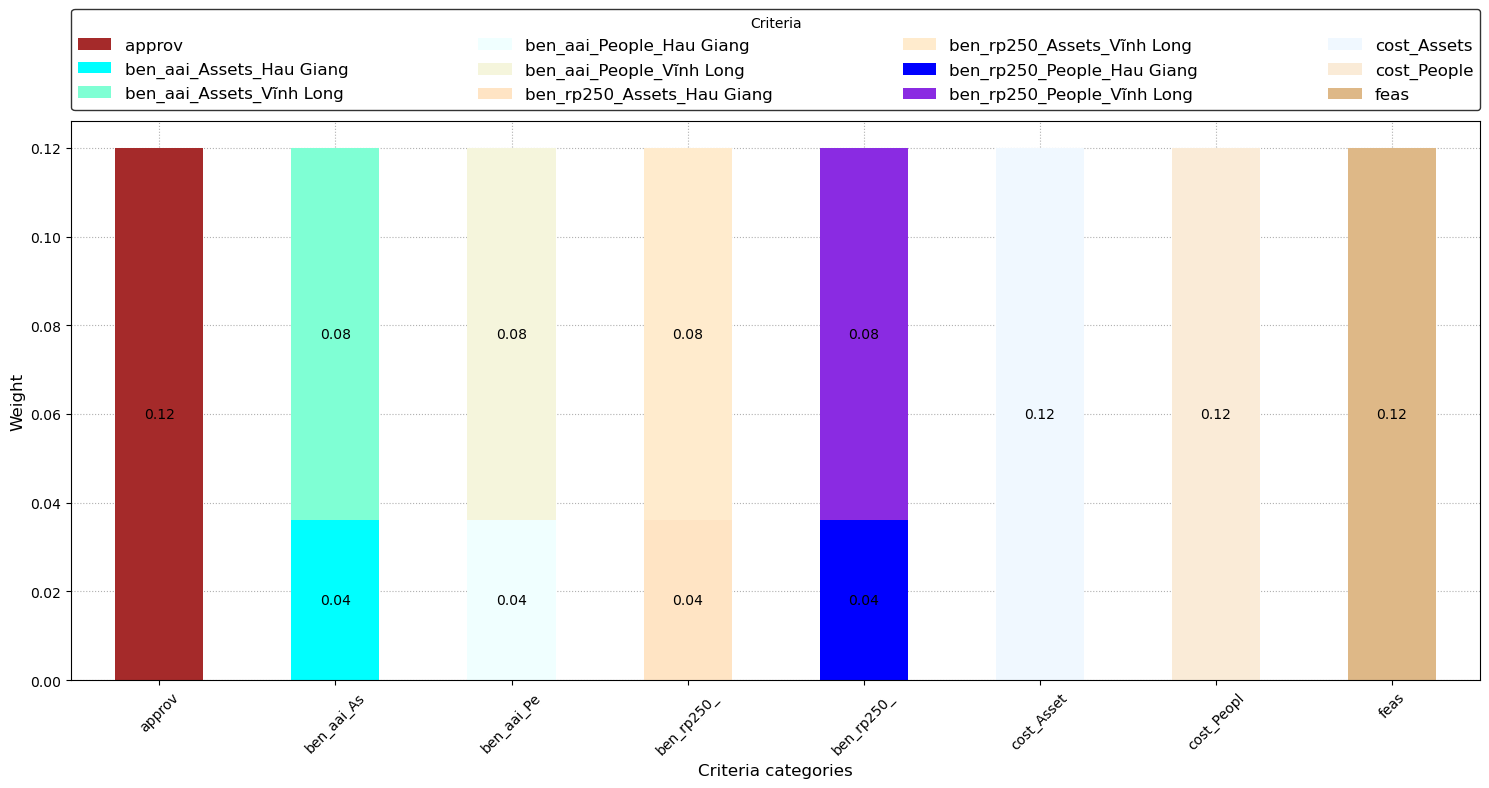

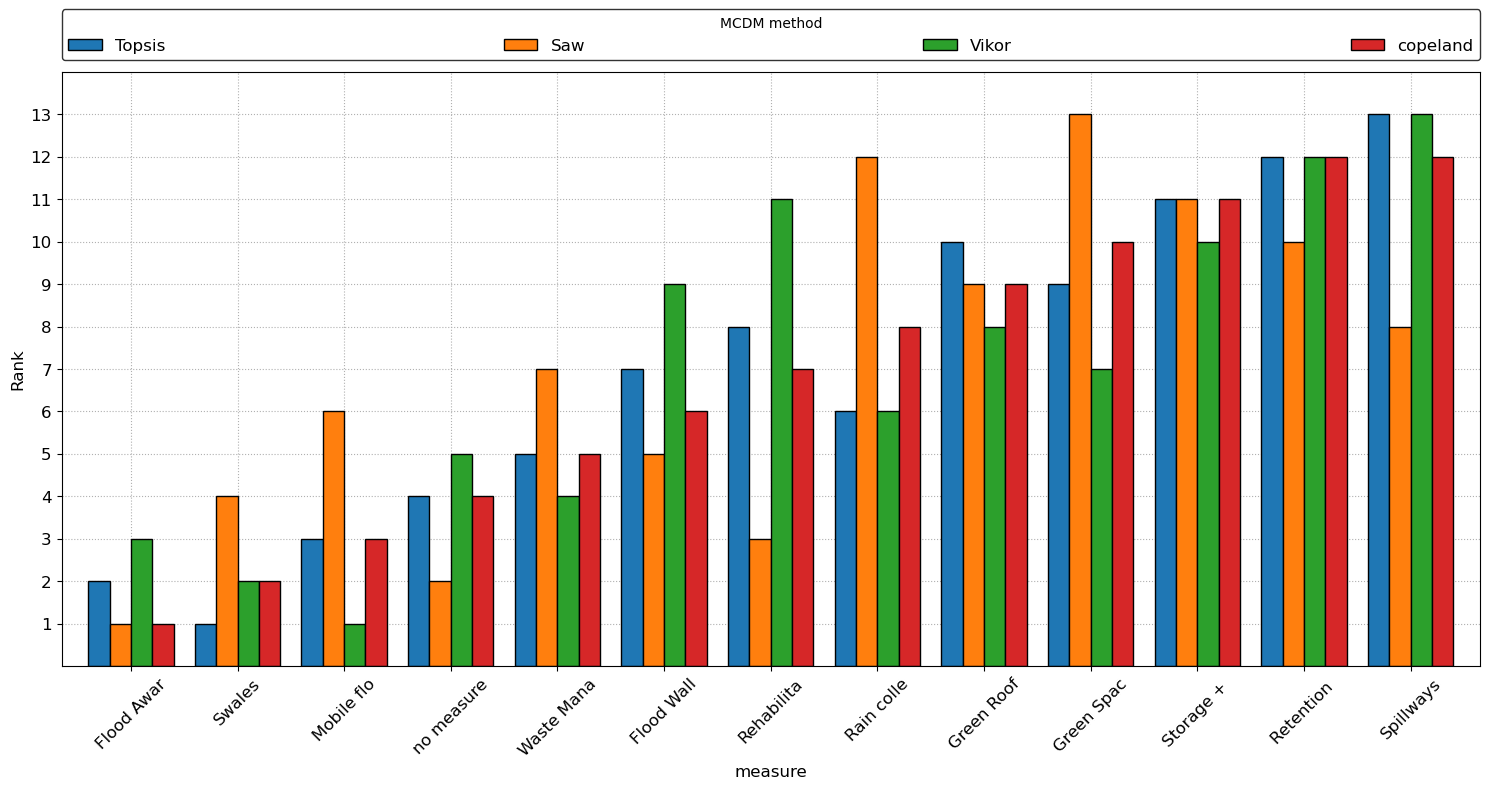

In [ ]:
# Or you can create a new decision matrix object with the groups as alternatives and the criteria as the alternatives
dm_piv = dm_groups.pivot_and_reweight_criteria(piv_col='admin1_info')

# Plot the criteria weights
dm_piv.plot_criteria(group_by_category=group_by_category)

# Rank the groups
ranks_output = dm_piv.calc_rankings()

# Print the rankings
ranks_output.plot_ranks(sort_by_col='copeland', alt_name_col='measure')
